In [283]:
import glob
import os
import omegaconf

import pandas as pd
import numpy as np
import random

import logging

from umap import UMAP

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.decomposition import PCA

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns


logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)


In [284]:
path_champollion = "/neurospin/dico/data/deep_folding/current/models/Champollion_V0"
participants_file = "/neurospin/dico/data/deep_folding/current/datasets/synesthetes/participants.csv"
embeddings_subpath = "synesthetes_random_embeddings/full_embeddings.csv"
ukb_embeddings_subpath = "ukb_random_embeddings/full_embeddings.csv"
output_filename = f"{path_champollion}/summary/isSynesthete_without_residualization.csv"
label = "isSynesthete"
max_iter = 2000
cv = 3

In [285]:
participants = pd.read_csv(participants_file, index_col=0)


In [286]:
participants.head()

,isSynesthete,NOM,DDN,IRM name,Date IRM,Âge,Sexe,Latéralité,Remarques,Code BV,Unnamed: 9,2=femme – 1=homme,0=droitier – 1=gaucher
participant_id,,,,,,,,,,,,,
mv_SYNESTHEX_3-Session1_S2_T1w,1,SARR,10/8/1996,Sujet01,28/2/2023,26.569863,2,0,NaN,3,NaN,NaN,NaN
mv_SYNESTHEX_S_Session1_S2_T1w,1,LEFR,14/12/1950,Sujet02,9/3/2023,72.282192,2,0,NaN,S,NaN,NaN,NaN
mv_SYNESTHEX_M_Session1_S2_T1w,1,FERN,NaN,Sujet03,NaN,23.680000,1,0,NaN,M,NaN,NaN,NaN
mv_SYNESTHEX_K_Session1_S2_T1w,1,DERO,27/6/1997,Sujet04,21/10/2023,26.334247,1,0,NaN,K,NaN,NaN,NaN
mv_SYNESTHEX_Sujet20_Session1_S2_T1w,1,DECH,NaN,Sujet05,NaN,21.110000,2,1,NaN,Sujet20,NaN,NaN,NaN


In [287]:
participants = participants[["isSynesthete", "Sexe", "Latéralité"]]

In [288]:
# participants[:] = participants.sample(frac=1).values

In [289]:
participants

,isSynesthete,Sexe,Latéralité
participant_id,,,
mv_SYNESTHEX_3-Session1_S2_T1w,1,2,0
mv_SYNESTHEX_S_Session1_S2_T1w,1,2,0
mv_SYNESTHEX_M_Session1_S2_T1w,1,1,0
mv_SYNESTHEX_K_Session1_S2_T1w,1,1,0
mv_SYNESTHEX_Sujet20_Session1_S2_T1w,1,2,1
mv_SYNESTHEX_Y_Session1_S2_T1w,1,1,0
mv_SYNESTHEX_Sujet25_Session1_S2_T1w,1,1,1
mv_SYNESTHEX_G_Session1_S2_T1w,1,2,0
mv_SYNESTHEX_D_Session1_S2_T1w,1,2,0


array([[<Axes: title={'center': 'isSynesthete'}>,
        <Axes: title={'center': 'Sexe'}>],
       [<Axes: title={'center': 'Latéralité'}>, <Axes: >]], dtype=object)

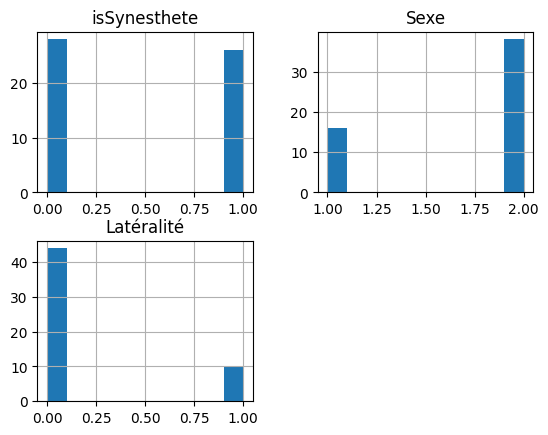

In [290]:
participants.hist()

In [291]:
def compute_umap(df, n_neighbors=15, n_components=2):
    # apply umap
    reducer = UMAP(n_neighbors=n_neighbors, n_components=n_components)
    visual_embs = reducer.fit_transform(df)
    return visual_embs, reducer

In [292]:
def is_it_a_file(sub_dir):
    if os.path.isdir(sub_dir):
        return False
    else:
        logging.debug(f"{sub_dir} is a file. Continue.")
        return True
    

def is_folder_a_model(sub_dir):
    if os.path.exists(sub_dir+'/.hydra/config.yaml'):
        return True
    else:
        logging.debug(f"\n{sub_dir} not associated to a model. Continue")
        return False

def get_model_paths(dir_path, result = None):
    """Recursively gets all models included in dir_path"""
    if result is None:  # create a new result if no intermediate was given
        result = [] 
    for name in os.listdir(dir_path):
        sub_dir = dir_path + '/' + name
        # checks if directory
        if is_it_a_file(sub_dir):
            pass
        elif not is_folder_a_model(sub_dir):
            result.extend(get_model_paths(sub_dir))
        else:
            result.append(sub_dir)
    return result

In [293]:
model_paths = get_model_paths(path_champollion)

In [294]:
model_paths[:5]

['/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117',
 '/neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1']

In [295]:
# df = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
# pca = PCA(n_components=1)
# df2 = pd.DataFrame(pca.fit_transform(df))
# df2.index = df.index
# df2


In [296]:
def compute(model_path, random_state):
    global embeddings
    global participants
    global results, X, Y, df2
    # Gets region name
    cfg = omegaconf.OmegaConf.load(model_path+'/.hydra/config.yaml')
    region = cfg['dataset'][next(iter(cfg['dataset']))]['crop_dir'].split('/')[-3]
    side = next(iter(cfg['dataset'])).split('_')[-1]
    region = region + '_' + side
    model_name = model_path.split('/')[-1]
    region_path = '/'.join(model_path.split('/')[-2:])
    print(f"Treating {region}: {region_path} : {model_path}")
    
    # Loads embeddings
    embeddings = pd.read_csv(f"{model_path}/{embeddings_subpath}", index_col=0)
    merged = participants[[label]].merge(embeddings, left_index=True, right_index=True)
    ukb_emb = pd.read_csv(f"{model_path}/{ukb_embeddings_subpath}", index_col=0)

    visual_ukb_emb, reducer = compute_umap(ukb_emb, n_neighbors=15, n_components=5)
    
    # Classifies
    X = merged.drop([label], axis=1)
    df2 = pd.DataFrame(reducer.transform(X))
    df2.index = X.index
    Y = merged[[label]]
    # df2 = X.copy()
    # pca = PCA(n_components=1)
    # df2 = pd.DataFrame(pca.fit_transform(X))
    # df2.index = X.index
    # scaler = StandardScaler()
    # df2[df2.columns] = scaler.fit_transform(df2)
    df2 = sm.add_constant(df2)
    model = sm.OLS(Y[label], df2)
    results = model.fit()
    f_value = results.fvalue
    p_value = results.f_pvalue

    # Gets result
    # roc_auc = roc_auc_score(Y, proba_pred[:,1])
    print(f_value)
    
    # Returns result
    return (region, f_value, p_value, model_name, region_path, model_path)

In [297]:
participants.dtypes

isSynesthete    int64
Sexe            int64
Latéralité      int64
dtype: object

In [298]:
result = []
for random_state in range(1):

    # Computes AUC
    for model_path in model_paths:
        result.append(compute(model_path, random_state))

Treating S.C.-sylv._left: SC-sylv_left/11-43-38_2 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/11-43-38_2
1.5050855690773541
Treating S.C.-sylv._left: SC-sylv_left/14-00-57_116 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_left/14-00-57_116
1.7636031246712327
Treating S.F.inter.-S.F.sup._left: SFinter-SFsup_left/09-33-02_0 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SFinter-SFsup_left/09-33-02_0
0.5172528655740913
Treating S.T.i.-S.T.s.-S.T.pol._right: STi-STs-STpol_right/20-15-00_117 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/STi-STs-STpol_right/20-15-00_117
1.4311193114525969
Treating F.Coll.-S.Rh._right: FColl-SRh_right/09-45-57_1 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/FColl-SRh_right/09-45-57_1
0.759429996147137
Treating S.C.-sylv._right: SC-sylv_right/11-43-38_3 : /neurospin/dico/data/deep_folding/current/models/Champollion_V0/SC-sylv_right/11-43-38

In [299]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           isSynesthete   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     2.999
Date:                Thu, 19 Sep 2024   Prob (F-statistic):             0.0196
Time:                        17:56:03   Log-Likelihood:                -31.815
No. Observations:                  54   AIC:                             75.63
Df Residuals:                      48   BIC:                             87.56
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4250      0.916     -1.555      0.126      -3.267       0.417
0             -0.0611      0.058     -1.061      0.294      -0.177       0.055
1             -0.1053      0.083     -1.267      0.211      -0.272       0.062
2              0.3021      0.089      3.393      0.001       0.123       0.481
3             -0.0414      0.085     -0.488      0.628      -0.212       0.129
4              0.1786      0.096      1.856      0.070      -0.015       0.372
==============================================================================
Omnibus:                       10.085   Durbin-Watson:                   0.536
Prob(Omnibus):                  0.006   Jarque-Bera (JB):                2.901
Skew:                          -0.048   Prob(JB):                        0.234
Kurtosis:                       1.869   Cond. No.                         166.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [300]:
df = pd.DataFrame(result, columns=['region', 'f_value', 'p_value', 'model_name', 'region_path', 'model_path'])

In [301]:
df

,region,f_value,p_value,model_name,region_path,model_path
0,S.C.-sylv._left,1.505086,0.205908,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...
1,S.C.-sylv._left,1.763603,0.138379,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...
2,S.F.inter.-S.F.sup._left,0.517253,0.761906,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...
3,S.T.i.-S.T.s.-S.T.pol._right,1.431119,0.230219,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...
4,F.Coll.-S.Rh._right,0.759430,0.583490,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...
...,...,...,...,...,...,...
71,S.F.inter.-S.F.sup._right,0.754919,0.586678,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...
72,S.T.s._left,1.274411,0.290400,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...
73,F.C.M.post.-S.p.C._right,0.359210,0.873771,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...
74,ORBITAL_right,1.172233,0.336604,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...


In [302]:
df['side'] = df['region'].str.split('_').str[-1]

In [303]:
df

,region,f_value,p_value,model_name,region_path,model_path,side
0,S.C.-sylv._left,1.505086,0.205908,11-43-38_2,SC-sylv_left/11-43-38_2,/neurospin/dico/data/deep_folding/current/mode...,left
1,S.C.-sylv._left,1.763603,0.138379,14-00-57_116,SC-sylv_left/14-00-57_116,/neurospin/dico/data/deep_folding/current/mode...,left
2,S.F.inter.-S.F.sup._left,0.517253,0.761906,09-33-02_0,SFinter-SFsup_left/09-33-02_0,/neurospin/dico/data/deep_folding/current/mode...,left
3,S.T.i.-S.T.s.-S.T.pol._right,1.431119,0.230219,20-15-00_117,STi-STs-STpol_right/20-15-00_117,/neurospin/dico/data/deep_folding/current/mode...,right
4,F.Coll.-S.Rh._right,0.759430,0.583490,09-45-57_1,FColl-SRh_right/09-45-57_1,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
71,S.F.inter.-S.F.sup._right,0.754919,0.586678,09-33-02_1,SFinter-SFsup_right/09-33-02_1,/neurospin/dico/data/deep_folding/current/mode...,right
72,S.T.s._left,1.274411,0.290400,11-43-38_0,STs_left/11-43-38_0,/neurospin/dico/data/deep_folding/current/mode...,left
73,F.C.M.post.-S.p.C._right,0.359210,0.873771,15-09-24_1,FCMpost-SpC_right/15-09-24_1,/neurospin/dico/data/deep_folding/current/mode...,right
74,ORBITAL_right,1.172233,0.336604,15-53-41_191,ORBITAL_right/15-53-41_191,/neurospin/dico/data/deep_folding/current/mode...,right


In [304]:
def plot_horizontal(res, region_name, ax, f_value, p_value, f2_value, visible, title):
    labelsize=10
    ax.xaxis.set_tick_params(labelsize = labelsize)
    ax.yaxis.set_tick_params(labelsize = labelsize)
    
    res = res.sort_values(by=f_value, ascending=True)

    # ax.errorbar(res[AUC_name], res[region_name], res[std_auc_name], fmt='s', color='black')
    # ax.scatter(res[AUC_name], res[region_name], marker='s', color='black')
    ax.axvline(x=0.05, color='black', linestyle='-')
    ax.barh(res[region_name], res[f2_value], fill=True, color='lightgray')
    ax.errorbar(res[f_value], res[region_name], xerr=0, fmt='s', color='black')
    # if visible:
    #     ax.set_ylabel("AUC ensemble")
    # else:
    #     ax.get_yaxis().set_ticks([])
    # ax.set_xlim((0.3, 1.0))
    ax.set_title(title)


In [313]:
0.05/56

0.0008928571428571429

In [312]:
df.sort_values(by="f_value", ascending=False)

,region,f_value,p_value,model_name,region_path,model_path,side
9,S.Po.C._left,3.731986,0.006200,18-08-26_0,SPoC_left/18-08-26_0,/neurospin/dico/data/deep_folding/current/mode...,left
34,S.C.-S.Pe.C._left,3.267633,0.012804,09-49-03_0,SC-SPeC_left/09-49-03_0,/neurospin/dico/data/deep_folding/current/mode...,left
10,S.F.inf.-BROCA-S.Pe.C.inf._right,3.232868,0.013524,12-25-50_1,SFinf-BROCA-SPeCinf_right/12-25-50_1,/neurospin/dico/data/deep_folding/current/mode...,right
75,S.C.-S.Po.C._left,2.999049,0.019563,14-55-36_0,SC-SPoC_left/14-55-36_0,/neurospin/dico/data/deep_folding/current/mode...,left
52,F.I.P._right,2.072701,0.085191,14-24-09_213_joel,FIP_right/14-24-09_213_joel,/neurospin/dico/data/deep_folding/current/mode...,right
...,...,...,...,...,...,...,...
49,S.F.median-S.F.pol.tr.-S.F.sup._left,0.196626,0.962307,18-09-26_0,SFmedian-SFpoltr-SFsup_left/18-09-26_0,/neurospin/dico/data/deep_folding/current/mode...,left
39,F.I.P._left,0.184066,0.967279,14-56-46_0,FIP_left/14-56-46_0,/neurospin/dico/data/deep_folding/current/mode...,left
40,F.I.P._left,0.149009,0.979386,14-56-46_4,FIP_left/14-56-46_4,/neurospin/dico/data/deep_folding/current/mode...,left
37,F.I.P._left,0.128105,0.985300,14-56-46_1,FIP_left/14-56-46_1,/neurospin/dico/data/deep_folding/current/mode...,left


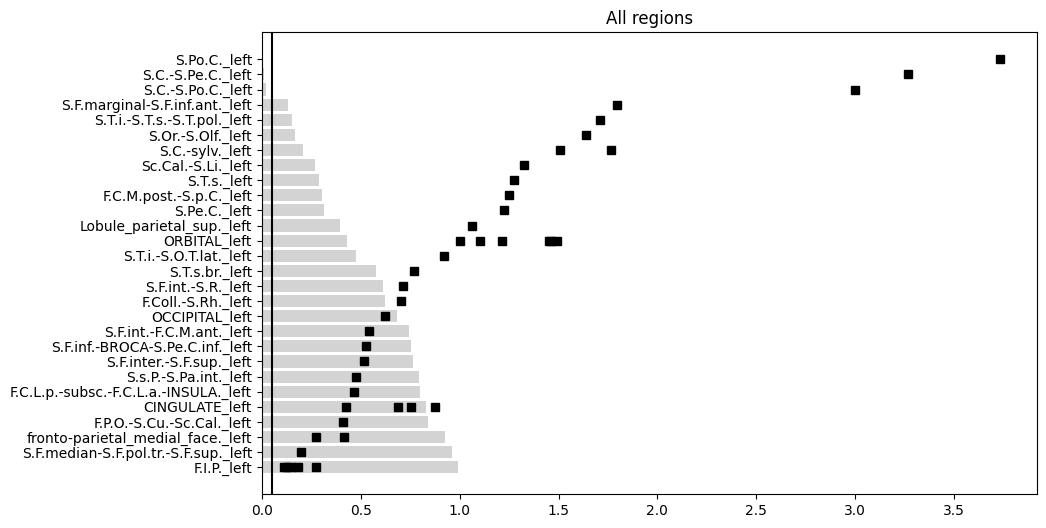

In [305]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='left'], "region", ax, "f_value", "f_value", "p_value",  True, "All regions")
plt.show()

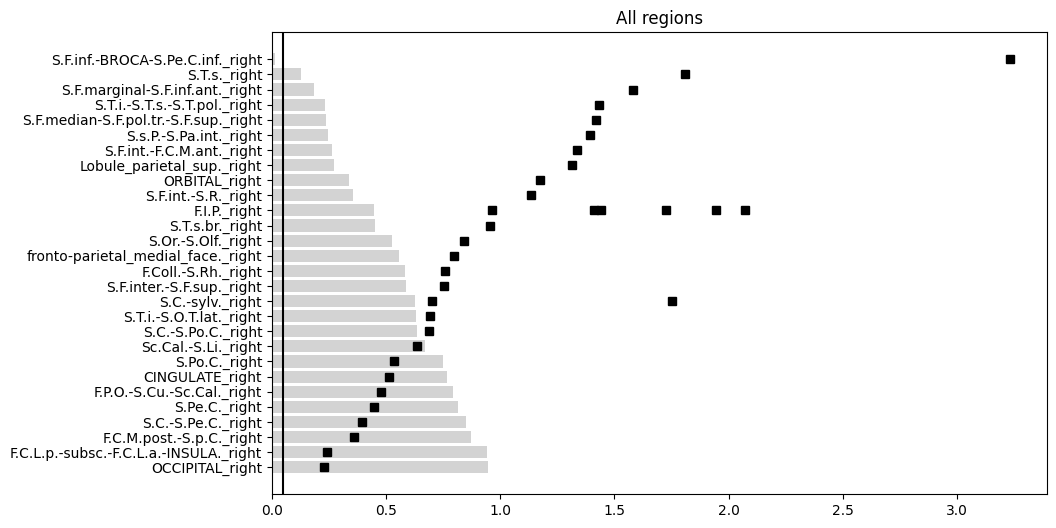

In [306]:
plt.rc('axes', labelsize=12) 
f, ax = plt.subplots(1, 1, figsize=(10, 6))
plot_horizontal(df[df.side=='right'], "region", ax, "f_value", "p_value", "p_value",  True, "All regions")
plt.show()

In [308]:
# df.to_csv(output_filename)